In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

We are doing the Canny Edge Detection below. 
In the following lines of code, we are blurring the image.

 kernel = 5                                    
 blur = cv2.GaussianBlur(gray,(kernel, kernel),0)
 
we need to blur the image before we pass it into the canny edge detection, this blurring is done in order to remove the noise level in the image.
An Edge detection on a sharp or a crip image will result in a lot of noise.

In [2]:
def canny(img):
    if img is None:             #if video is not running it will close
        cap.release()
        cv2.destroyAllWindows()
        exit()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
    kernel = 5                                      
    blur = cv2.GaussianBlur(gray,(kernel, kernel),0)
    canny = cv2.Canny(gray, 50, 150)
    return canny

Below we are trying to crop the area of the image in which the lane is present. 
We define the vertex of the Triangles of which the lanes are a part and ignore rest. 

In [3]:
def region_of_interest(canny):
    height = canny.shape[0]
    width = canny.shape[1]
    mask = np.zeros_like(canny)
    triangle = np.array([[
    (200, height),
    (800, 350),
    (1200, height),]], np.int32)
    cv2.fillPoly(mask, triangle, 255)
    masked_image = cv2.bitwise_and(canny, mask)
    return masked_image

Below we are identifying the lines in the images by using hough line detection algorithm.

In [4]:
def houghLines(cropped_canny):
    return cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100, 
        np.array([]), minLineLength=40, maxLineGap=5)

Below, as we want to see both the lane as well as the lines drawn, so give a weightage to each 

In [5]:
def addWeighted(frame, line_image):
    return cv2.addWeighted(frame, 0.8, line_image, 1, 1)

Below, we are trying to get the location of the detected lines, i.e. the slope and intercept of the lines. 

In [6]:
def average_slope_intercept(image, lines):
    left_fit    = []
    right_fit   = []
    if lines is None:
        return None
    for line in lines:
        for x1, y1, x2, y2 in line:
            fit = np.polyfit((x1,x2), (y1,y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0: 
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))
    left_fit_average  = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line  = make_points(image, left_fit_average)
    right_line = make_points(image, right_fit_average)
    averaged_lines = [left_line, right_line]
    return averaged_lines

Below we are simply drawing the lines on the image

In [7]:
def display_lines(img,lines):
    line_image = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
    return line_image

Below, using the slope of the lines and image size, to see which lines can be the lanes.
This will depends on the video or images that we are using. These are assumptions for this particular video file.

In [8]:
def make_points(image, line):
    slope, intercept = line
    y1 = int(image.shape[0])
    y2 = int(y1*3.0/5)      
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]

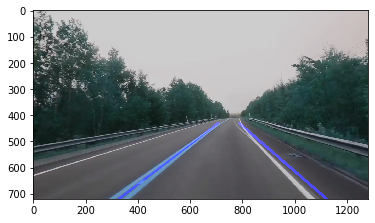

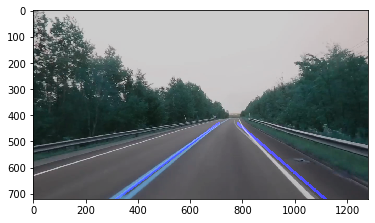

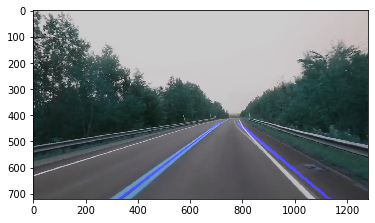

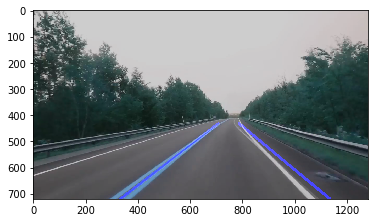

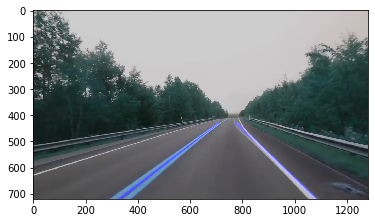

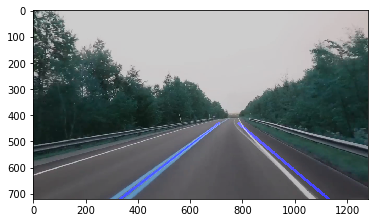

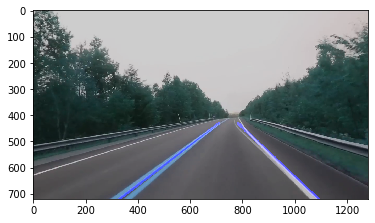

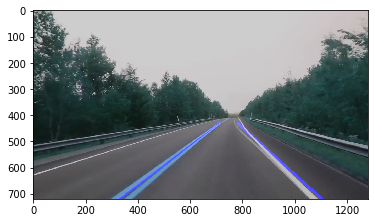

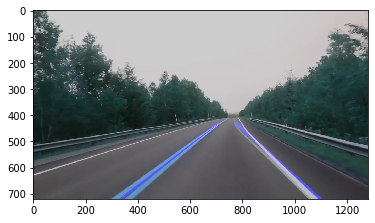

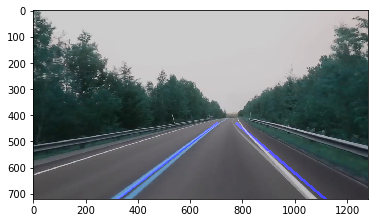

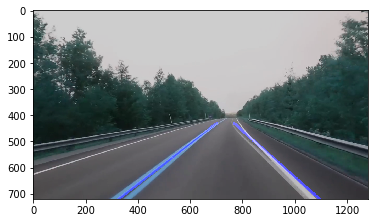

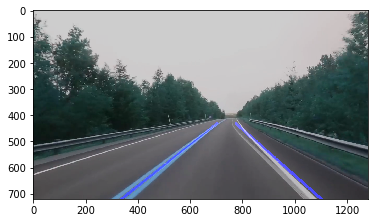

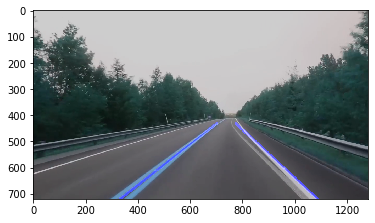

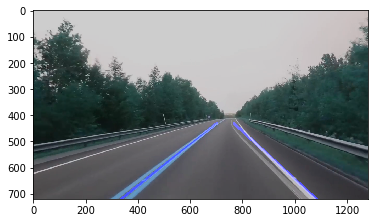

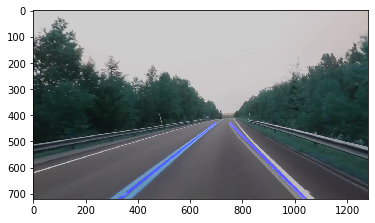

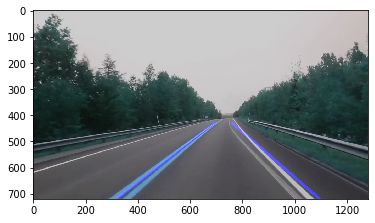

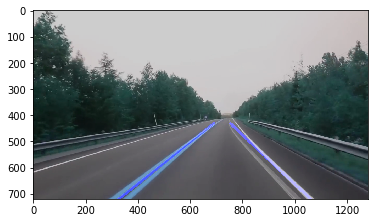

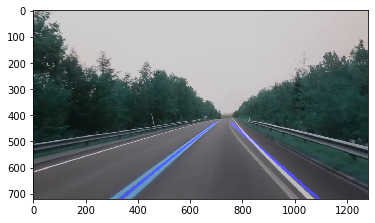

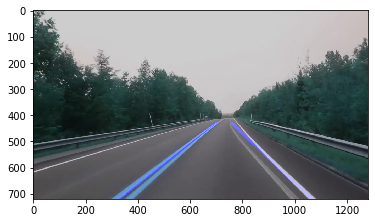

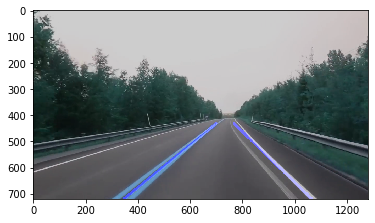

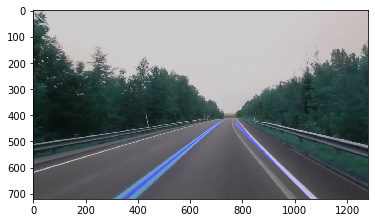

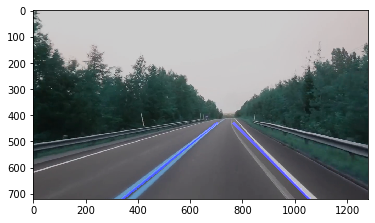

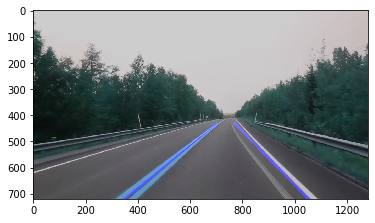

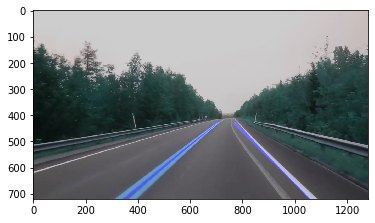

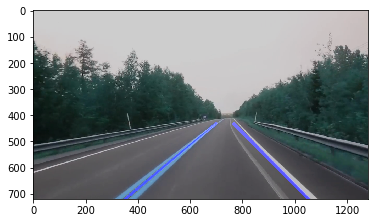

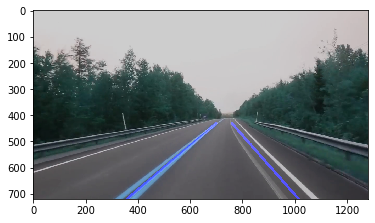

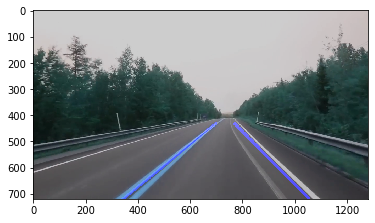

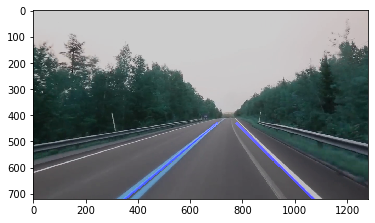

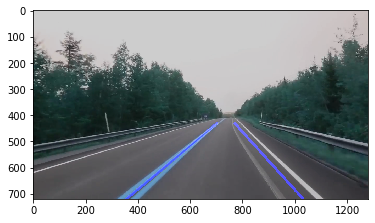

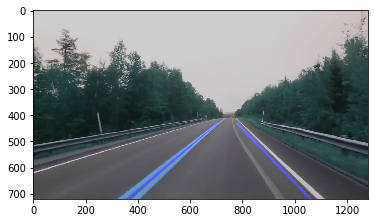

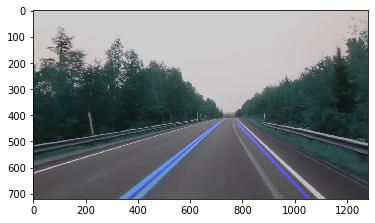

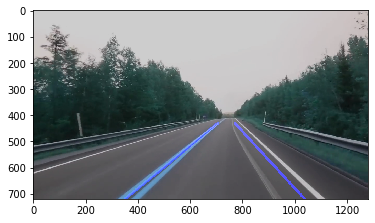

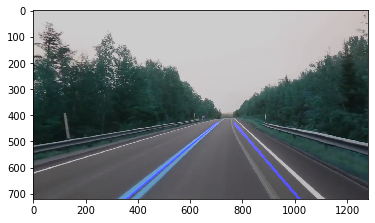

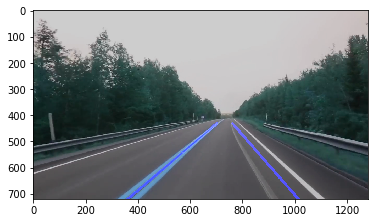

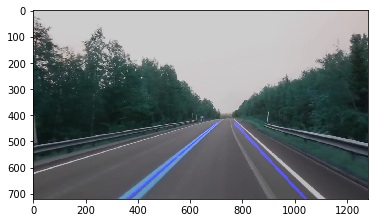

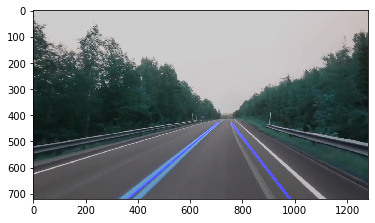

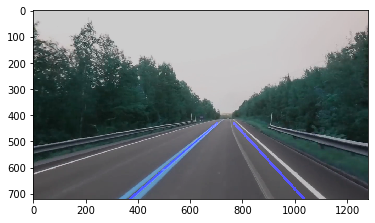

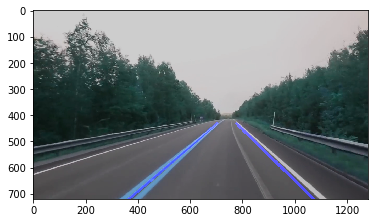

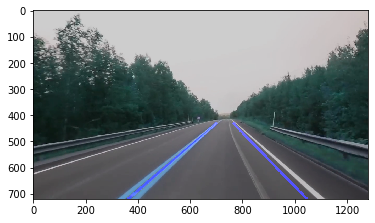

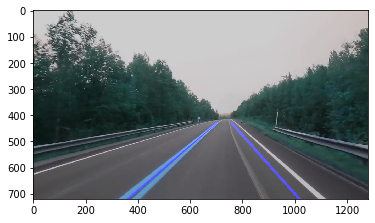

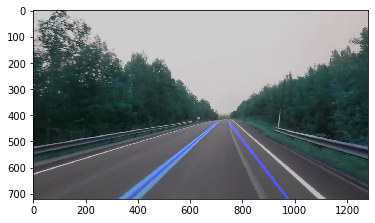

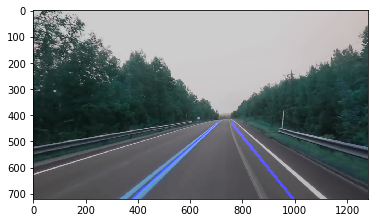

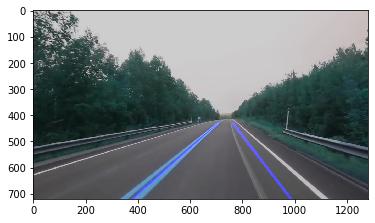

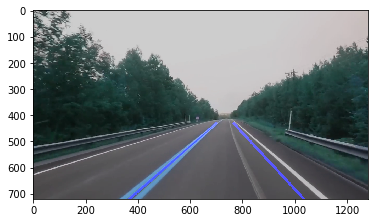

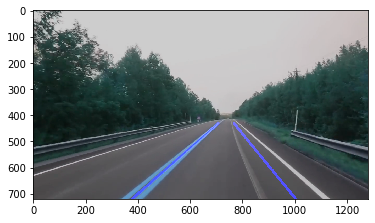

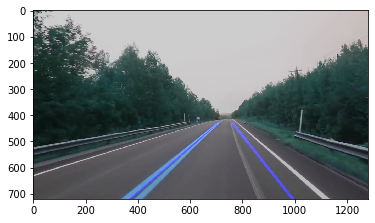

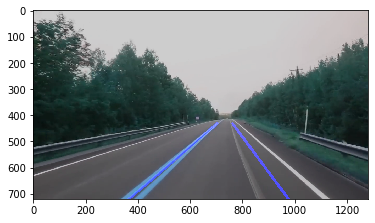

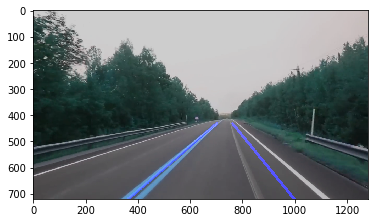

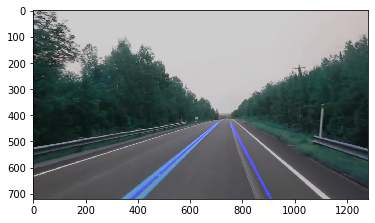

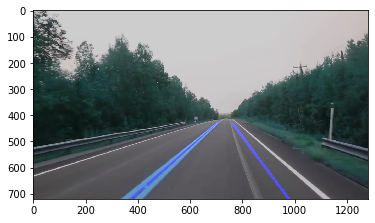

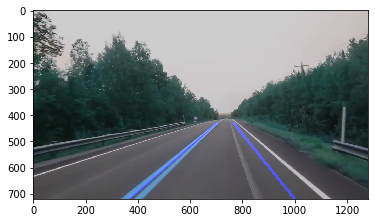

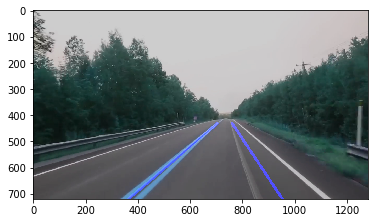

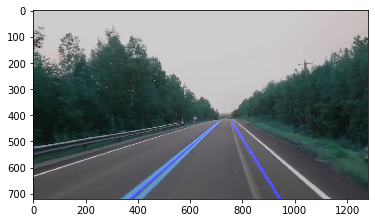

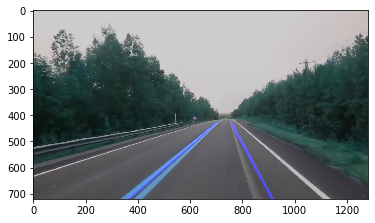

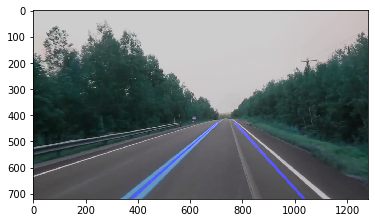

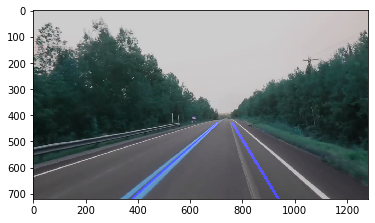

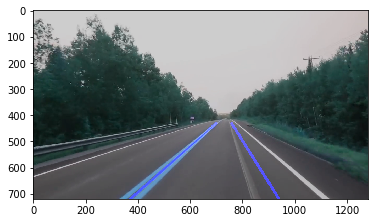

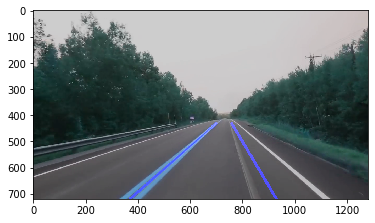

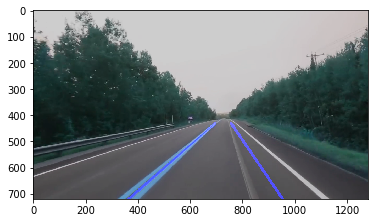

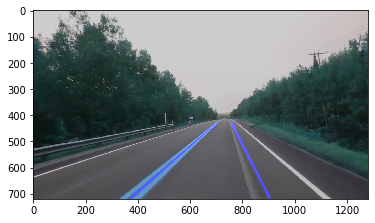

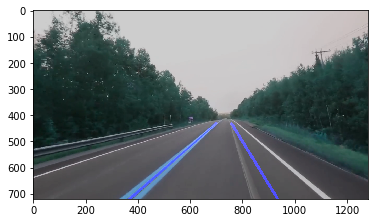

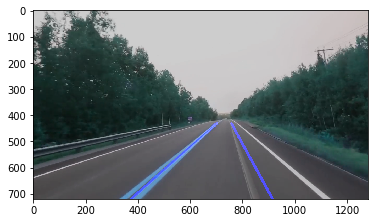

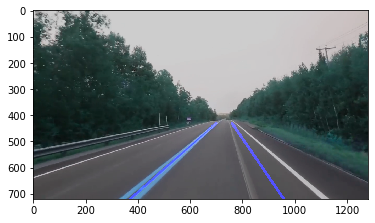

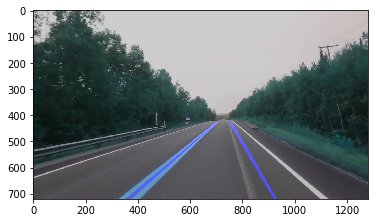

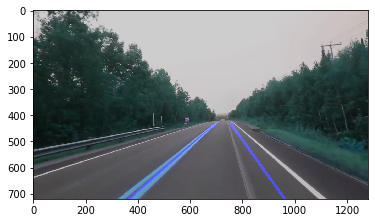

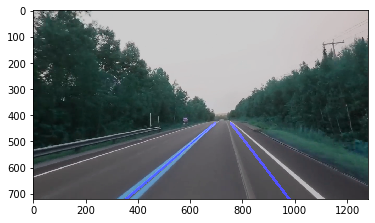

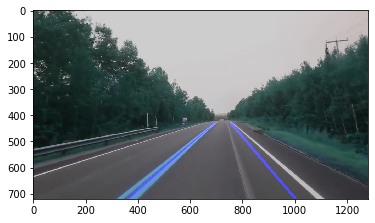

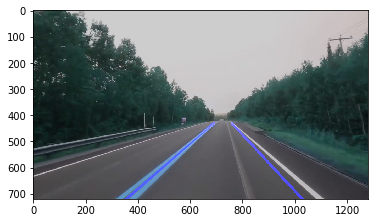

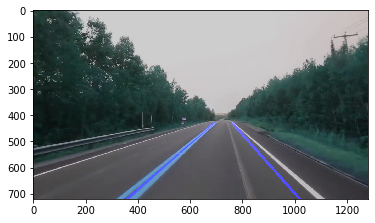

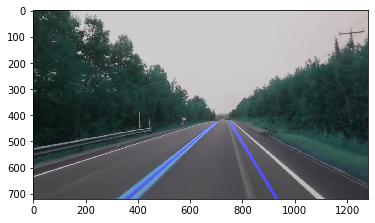

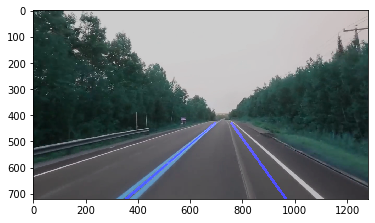

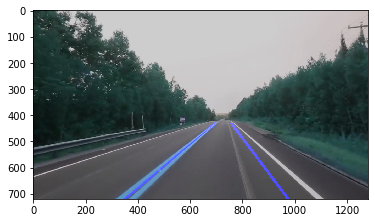

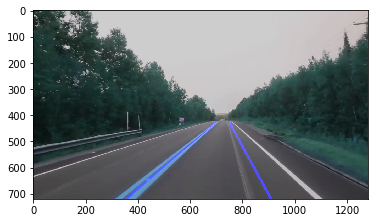

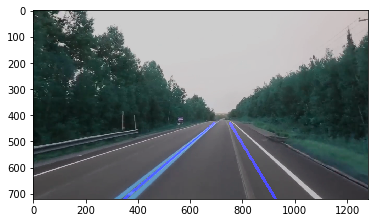

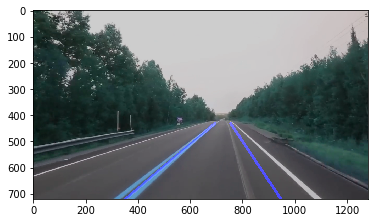

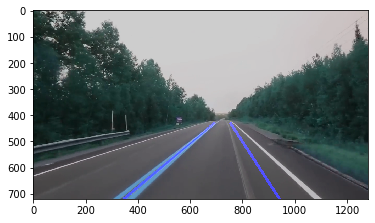

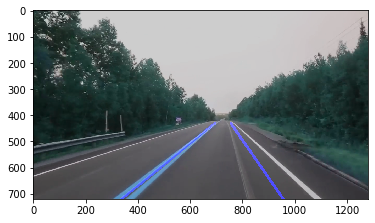

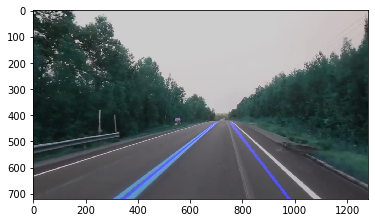

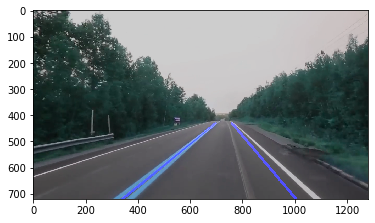

In [ ]:
cap = cv2.VideoCapture("test1.mp4")   
while(cap.isOpened()):
    _, frame = cap.read()      
    canny_image = canny(frame)   
    cropped_canny = region_of_interest(canny_image)
    lines = houghLines(cropped_canny)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combo_image = addWeighted(frame, line_image)
    plt.imshow(combo_image)
    plt.show()
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()